Found 6 data files.
3547: p = 0.061563398594062124
5262: p = 0.022464730556831344
5299: p = 0.6796062527235118
6566: p = 0.08707440782228668
8519: p = 0.5649253193062427
Seltorexant: p = 1.5022734393310388e-06


/tmp/ipykernel_2992644/3066535151.py:122: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


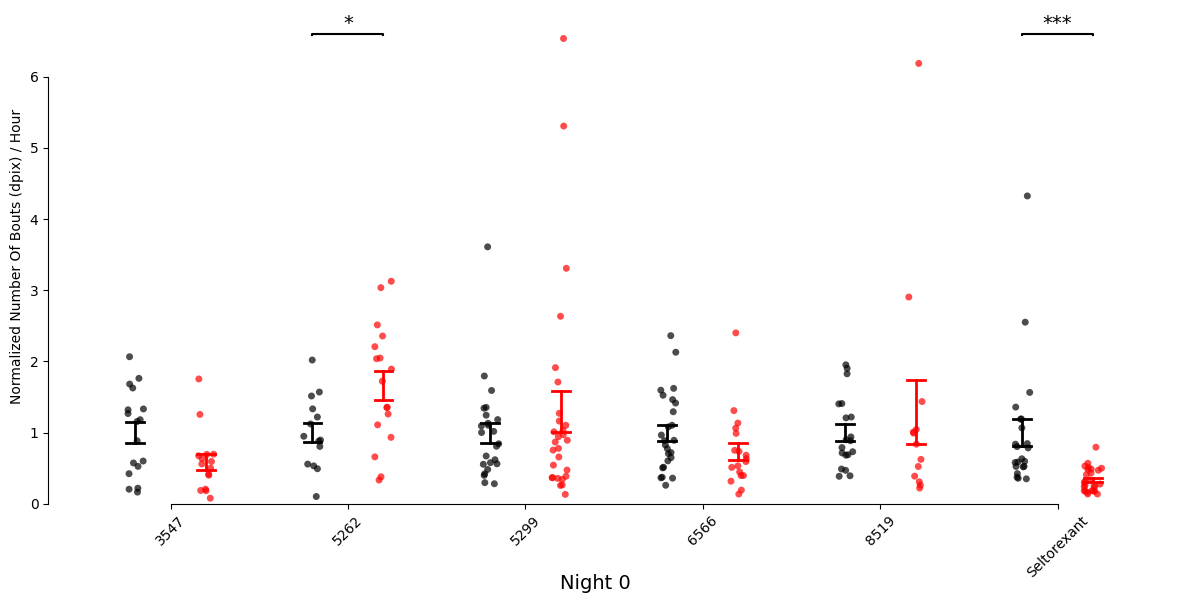

In [5]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# -----------------------------
# 1️⃣ Load and normalize data
# -----------------------------
base_dir = os.getcwd()
pattern = os.path.join(base_dir, "*", "hs_hcrt", 
                       "boxgraph_ribgraph_mean_time_day0night_dpix_numberofbouts_600.png_data.csv")
files = glob.glob(pattern)
print(f"Found {len(files)} data files.")

all_data = []
for file in files:
    df = pd.read_csv(file, sep="\t")
    
    # Normalize relative to DMSO mean per experiment
    dmso_mean = df["dmso"].mean()
    df["dmso_norm"] = df["dmso"] / dmso_mean
    df["drug_norm"] = df["drug"] / dmso_mean
    
    # Add experiment metadata
    experiment_id = os.path.basename(os.path.dirname(os.path.dirname(file)))
    
    if len(experiment_id.split("_")) > 1:
        experiment_id = experiment_id.split("_")[1]
    
    df["experiment"] = experiment_id
    
    all_data.append(df[["experiment", "dmso_norm", "drug_norm"]])

merged_df = pd.concat(all_data, ignore_index=True)

# Sort merged_df alphabetically by experiment name
merged_df = merged_df.sort_values(by="experiment").reset_index(drop=True)

# -----------------------------
# 2️⃣ MAD-based outlier removal
# -----------------------------
def remove_outliers_mad(df, threshold=3.0):
    df_filtered = df.copy()
    for col in ["dmso_norm", "drug_norm"]:
        for exp in df_filtered["experiment"].unique():
            mask = df_filtered["experiment"] == exp
            med = df_filtered.loc[mask, col].median()
            mad = np.median(np.abs(df_filtered.loc[mask, col] - med))
            # Avoid division by zero if MAD = 0
            if mad == 0:
                continue
            # Set outliers to NaN
            df_filtered.loc[mask & (np.abs(df_filtered[col] - med) > threshold * mad), col] = np.nan
    return df_filtered

#merged_df = remove_outliers_mad(merged_df)

# -----------------------------
# 3️⃣ Convert to long format
# -----------------------------
plot_df = merged_df.melt(
    id_vars="experiment", 
    value_vars=["dmso_norm", "drug_norm"],
    var_name="treatment",
    value_name="normalized_response"
)
plot_df["treatment"] = plot_df["treatment"].str.replace("_norm", "")

# -----------------------------
# 4️⃣ Mann–Whitney U test per experiment
# -----------------------------
pvals = {}
for exp in plot_df["experiment"].unique():
    data_exp = plot_df[plot_df["experiment"] == exp]
    dmso_vals = data_exp[data_exp["treatment"] == "dmso"]["normalized_response"].dropna()
    drug_vals = data_exp[data_exp["treatment"] == "drug"]["normalized_response"].dropna()
    
    if len(dmso_vals) >= 2 and len(drug_vals) >= 2:
        _, p_val = mannwhitneyu(dmso_vals, drug_vals, alternative='two-sided')
    else:
        p_val = np.nan
    pvals[exp] = p_val
    
# Print p-values
for exp, p in pvals.items():
    print(f"{exp}: p = {p}")

# -----------------------------
# 5️⃣ Helper: p-value to stars
# -----------------------------
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# -----------------------------
# 6️⃣ Plot
# -----------------------------
plt.figure(figsize=(12,6))

# Stripplot (points) with legend
sns.stripplot(
    data=plot_df,
    x="experiment",
    y="normalized_response",
    hue="treatment",
    dodge=True,
    alpha=0.7,
    palette={"dmso": "black", "drug": "red"},
    legend=False
)

# Barplot (mean ± SEM, outlined)
sns.barplot(
    data=plot_df,
    x="experiment",
    y="normalized_response",
    hue="treatment",
    estimator=np.mean,
    errorbar=("se", 1),
    dodge=True,
    alpha=0,
    fill=False,
    palette={"dmso": "black", "drug": "red"},
    linewidth=2,
    capsize=0.2,
    errwidth=2,
    legend=False
)

# Remove top/right spines
sns.despine(trim=True)

# Legend in top right
#plt.legend(title="Treatment", loc="upper left")

plt.xticks(rotation=45)
plt.ylabel("Normalized Number Of Bouts (dpix) / Hour")
plt.xlabel("")

# Determine y positions for significance stars/brackets
y_max_global = plot_df["normalized_response"].max()
offset = 0.05  # vertical space above bars for bracket start

for i, exp in enumerate(plot_df["experiment"].unique()):
    p_val = pvals[exp]
    stars = p_to_stars(p_val)
    
    if stars != "ns":
        # Draw bracket line
        bar_width = 0.2  # horizontal extent of bracket
        x1 = i - bar_width
        x2 = i + bar_width
        y = y_max_global + 0.05
        plt.plot([x1, x1, x2, x2], [y, y+0.02, y+0.02, y], color="black", lw=1.5)
        
        # Add stars above bracket
        plt.text(i, y + 0.025, stars, ha='center', va='bottom', fontsize=14)

# Move title below the plot
plt.figtext(0.5, 0.01, "Night 0",
            ha="center", fontsize=14)

plt.tight_layout()
plt.show()





Found 6 data files.
3547: p = 8.589568340715082e-05
5262: p = 0.27501302114502435
5299: p = 0.6137145025248794
6566: p = 0.17969417851545832
8519: p = 0.0419940620636736
Seltorexant: p = 0.11344216110205965


/tmp/ipykernel_2992644/3811467410.py:124: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


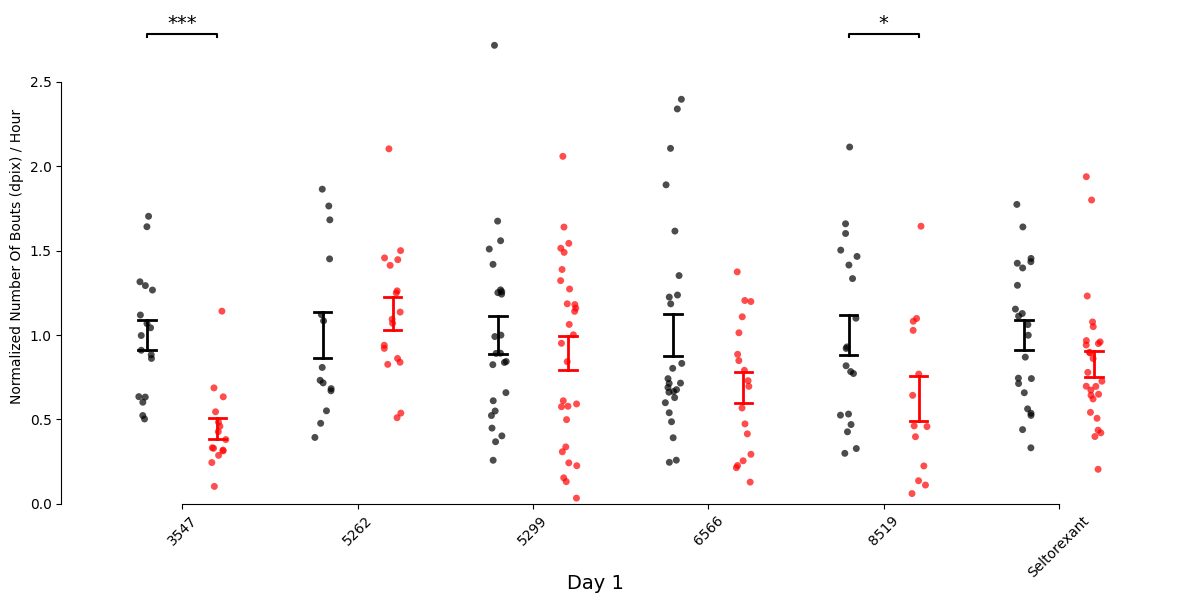

In [6]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# -----------------------------
# 1️⃣ Load and normalize data
# -----------------------------
base_dir = os.getcwd()
pattern = os.path.join(base_dir, "*", "hs_hcrt", 
                       "boxgraph_ribgraph_mean_time_day1day_dpix_numberofbouts_600.png_data.csv")
files = glob.glob(pattern)
print(f"Found {len(files)} data files.")

all_data = []
for file in files:
    df = pd.read_csv(file, sep="\t")
    
    # Normalize relative to DMSO mean per experiment
    dmso_mean = df["dmso"].mean()
    df["dmso_norm"] = df["dmso"] / dmso_mean
    df["drug_norm"] = df["drug"] / dmso_mean
    
    # Add experiment metadata
    experiment_id = os.path.basename(os.path.dirname(os.path.dirname(file)))
    
    if len(experiment_id.split("_")) > 1:
        experiment_id = experiment_id.split("_")[1]
    
    df["experiment"] = experiment_id
    
    df["experiment"] = experiment_id
    
    all_data.append(df[["experiment", "dmso_norm", "drug_norm"]])

merged_df = pd.concat(all_data, ignore_index=True)

# Sort merged_df alphabetically by experiment name
merged_df = merged_df.sort_values(by="experiment").reset_index(drop=True)

# -----------------------------
# 2️⃣ MAD-based outlier removal
# -----------------------------
def remove_outliers_mad(df, threshold=3.0):
    df_filtered = df.copy()
    for col in ["dmso_norm", "drug_norm"]:
        for exp in df_filtered["experiment"].unique():
            mask = df_filtered["experiment"] == exp
            med = df_filtered.loc[mask, col].median()
            mad = np.median(np.abs(df_filtered.loc[mask, col] - med))
            # Avoid division by zero if MAD = 0
            if mad == 0:
                continue
            # Set outliers to NaN
            df_filtered.loc[mask & (np.abs(df_filtered[col] - med) > threshold * mad), col] = np.nan
    return df_filtered

#merged_df = remove_outliers_mad(merged_df)

# -----------------------------
# 3️⃣ Convert to long format
# -----------------------------
plot_df = merged_df.melt(
    id_vars="experiment", 
    value_vars=["dmso_norm", "drug_norm"],
    var_name="treatment",
    value_name="normalized_response"
)
plot_df["treatment"] = plot_df["treatment"].str.replace("_norm", "")

# -----------------------------
# 4️⃣ Mann–Whitney U test per experiment
# -----------------------------
pvals = {}
for exp in plot_df["experiment"].unique():
    data_exp = plot_df[plot_df["experiment"] == exp]
    dmso_vals = data_exp[data_exp["treatment"] == "dmso"]["normalized_response"].dropna()
    drug_vals = data_exp[data_exp["treatment"] == "drug"]["normalized_response"].dropna()
    
    if len(dmso_vals) >= 2 and len(drug_vals) >= 2:
        _, p_val = mannwhitneyu(dmso_vals, drug_vals, alternative='two-sided')
    else:
        p_val = np.nan
    pvals[exp] = p_val
    
# Print p-values
for exp, p in pvals.items():
    print(f"{exp}: p = {p}")

# -----------------------------
# 5️⃣ Helper: p-value to stars
# -----------------------------
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# -----------------------------
# 6️⃣ Plot
# -----------------------------
plt.figure(figsize=(12,6))

# Stripplot (points) with legend
sns.stripplot(
    data=plot_df,
    x="experiment",
    y="normalized_response",
    hue="treatment",
    dodge=True,
    alpha=0.7,
    palette={"dmso": "black", "drug": "red"},
    legend=False
)

# Barplot (mean ± SEM, outlined)
sns.barplot(
    data=plot_df,
    x="experiment",
    y="normalized_response",
    hue="treatment",
    estimator=np.mean,
    errorbar=("se", 1),
    dodge=True,
    alpha=0,
    fill=False,
    palette={"dmso": "black", "drug": "red"},
    linewidth=2,
    capsize=0.2,
    errwidth=2,
    legend=False
)

# Remove top/right spines
sns.despine(trim=True)

# Legend in top right
#plt.legend(title="Treatment", loc="upper left")

plt.xticks(rotation=45)
plt.ylabel("Normalized Number Of Bouts (dpix) / Hour")
plt.xlabel("")

# Determine y positions for significance stars/brackets
y_max_global = plot_df["normalized_response"].max()
offset = 0.05  # vertical space above bars for bracket start

for i, exp in enumerate(plot_df["experiment"].unique()):
    p_val = pvals[exp]
    stars = p_to_stars(p_val)
    
    if stars != "ns":
        # Draw bracket line
        bar_width = 0.2  # horizontal extent of bracket
        x1 = i - bar_width
        x2 = i + bar_width
        y = y_max_global + 0.05
        plt.plot([x1, x1, x2, x2], [y, y+0.02, y+0.02, y], color="black", lw=1.5)
        
        # Add stars above bracket
        plt.text(i, y + 0.025, stars, ha='center', va='bottom', fontsize=14)

# Move title below the plot
plt.figtext(0.5, 0.01, "Day 1",
            ha="center", fontsize=14)

plt.tight_layout()
plt.show()



